# Reading dataset and combining tables

In [34]:
import pandas as pd
import numpy as np
import os
from scipy.stats import poisson
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

directory = 'C:/Users/99451/Desktop/MODEL/old/eng_prem'

dfs = []

# Define the columns you want to extract from each CSV file
columns_to_keep = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'FTR', 'HST', 'AST', 'B365H', 'B365D', 'B365A']

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(directory, filename), on_bad_lines = 'skip', encoding='latin-1')
        df = df[columns_to_keep]
        dfs.append(df)

my_df = pd.concat(dfs, ignore_index=True)

print("Number of rows:", my_df.shape[0])
print("Number of columns:", my_df.shape[1])
my_df.head(5)

Number of rows: 8651
Number of columns: 13


,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,FTR,HST,AST,B365H,B365D,B365A
0,17/08/2002,Blackburn,Sunderland,0.0,0.0,0.0,0.0,D,5.0,3.0,1.727,3.25,4.333
1,17/08/2002,Charlton,Chelsea,2.0,3.0,2.0,1.0,A,5.0,12.0,2.800,3.25,2.200
2,17/08/2002,Everton,Tottenham,2.0,2.0,1.0,0.0,D,9.0,5.0,2.250,3.25,2.750
3,17/08/2002,Fulham,Bolton,4.0,1.0,3.0,1.0,H,6.0,1.0,1.727,3.25,4.333
4,17/08/2002,Leeds,Man City,3.0,0.0,2.0,0.0,H,8.0,10.0,1.667,3.40,4.500


# Adding Moving Average Columns

In [35]:
#Creating a copy of my_df to work on
df = my_df.copy()

#Calculating Points Per Game for Home and Away Teams
df['HPTS'] = np.select([df['FTR'] == 'H', df['FTR'] == 'D', df['FTR'] == 'A'], [3, 1, 0], default=0)
df['APTS'] = np.select([df['FTR'] == 'H', df['FTR'] == 'D', df['FTR'] == 'A'], [0, 1, 3], default=0)

df['HPPG'] = df.groupby('HomeTeam')['HPTS'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['APPG'] = df.groupby('AwayTeam')['APTS'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['form_dif'] = df['HPPG'] - df['APPG'] #calculating form difference home points per game - away points per game

#Calculating scored and conceded goals
df['FTHGS'] = df.groupby('HomeTeam')['FTHG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['FTHGC'] = df.groupby('HomeTeam')['FTAG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

df['FTAGS'] = df.groupby('AwayTeam')['FTAG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['FTAGC'] = df.groupby('AwayTeam')['FTHG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

#Calculating scored and conceded goals for halftime
df['HTHGS'] = df.groupby('HomeTeam')['HTHG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['HTHGC'] = df.groupby('HomeTeam')['HTAG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

df['HTAGS'] = df.groupby('AwayTeam')['HTAG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['HTAGC'] = df.groupby('AwayTeam')['HTHG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

#Calculating shots on target for home/away
df['HSTS'] = df.groupby('HomeTeam')['HST'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['HSTC'] = df.groupby('HomeTeam')['AST'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

df['ASTS'] = df.groupby('AwayTeam')['AST'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['ASTC'] = df.groupby('AwayTeam')['HST'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

df['st_dif'] = df['HSTS'] - df['ASTS']

#Calculating odds probabilities
total = 1 / df['B365H'] + 1 / df['B365D'] + 1 / df['B365A']

df['FTH'] = (1 / df['B365H']) / total
df['FTD'] = (1 / df['B365D']) / total
df['FTA'] = (1 / df['B365A']) / total
df['FTDA'] = df['FTD'] + df['FTA']

# Calculate the league-wide moving average for home_goals and away_goals
df['league_home_goals'] = df['FTHG'].rolling(50, min_periods=1).mean().shift(1)
df['league_away_goals'] = df['FTAG'].rolling(50, min_periods=1).mean().shift(1)

df['ht_league_home_goals'] = df['HTHG'].rolling(50, min_periods=1).mean().shift(1)
df['ht_league_away_goals'] = df['HTAG'].rolling(50, min_periods=1).mean().shift(1)

#Calculating Poisson Statistics for Full/Halftime
df['home_attack'] = df['FTHGS'] / df['league_home_goals']
df['home_defence'] = df['FTHGC'] / df['league_away_goals']
df['away_attack'] = df['FTAGS'] / df['league_away_goals']
df['away_defence'] = df['FTAGC'] / df['league_home_goals']

df['ht_home_attack'] = df['HTHGS'] / df['ht_league_home_goals']
df['ht_home_defence'] = df['HTHGC'] / df['ht_league_away_goals']
df['ht_away_attack'] = df['HTAGS'] / df['ht_league_away_goals']
df['ht_away_defence'] = df['HTAGC'] / df['ht_league_home_goals']

df['home_xg'] = df['home_attack'] * df['away_defence'] * df['league_home_goals']
df['away_xg'] = df['away_attack'] * df['home_defence'] * df['league_away_goals']

df['ht_home_xg'] = df['ht_home_attack'] * df['ht_away_defence'] * df['ht_league_home_goals']
df['ht_away_xg'] = df['ht_away_attack'] * df['ht_home_defence'] * df['ht_league_away_goals']

df.dropna(inplace = True)
df = df.reset_index(drop = True)

df['home_poisson'] = df['home_xg'].apply(lambda lmbda: np.nanargmax(
    [poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) 
    if not pd.isnull(lmbda) and any([poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) else 0)

df['away_poisson'] = df['away_xg'].apply(lambda lmbda: np.nanargmax(
    [poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) 
    if not pd.isnull(lmbda) and any([poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) else 0)

df['ht_home_poisson'] = df['ht_home_xg'].apply(lambda lmbda: np.nanargmax(
    [poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) 
    if not pd.isnull(lmbda) and any([poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) else 0)

df['ht_away_poisson'] = df['ht_away_xg'].apply(lambda lmbda: np.nanargmax(
    [poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) 
    if not pd.isnull(lmbda) and any([poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) else 0)

df['poisson_df'] = df['home_poisson'] - df['away_poisson']
df['ht_poisson_df'] = df['ht_home_poisson'] - df['ht_away_poisson']
df['FTRT'] = [1 if x == 'H' else 0 for x in df['FTR']]

#Removing unnessary columns
df.drop(['Date', 'FTHG', 'FTAG', 'HPTS', 'APTS', 'FTHGS', 'FTHGC', 'FTAGS', 'FTAGC',
            'FTD', 'FTA', 'league_home_goals', 'league_away_goals', 'home_attack', 'home_defence', 'FTDA',
            'away_attack', 'away_defence', 'home_xg', 'away_xg', 'HPPG', 'APPG', 'home_poisson', 'away_poisson',
            'HST', 'AST', 'HSTC', 'ASTC', 'HTHG', 'HTAG', 'FTR', 'HSTS', 'ASTS',
            'ht_league_home_goals', 'ht_league_away_goals', 'ht_home_attack', 'ht_home_defence', 'ht_away_attack',
            'ht_away_defence', 'ht_home_xg', 'ht_away_xg', 'ht_home_poisson', 'ht_away_poisson',
            'HTHGS', 'HTHGC', 'HTAGS', 'HTAGC'], axis = 1, inplace = True)

df[df['HomeTeam'] == 'Sunderland'].head(7)

,HomeTeam,AwayTeam,B365H,B365D,B365A,form_dif,st_dif,FTH,poisson_df,ht_poisson_df,FTRT
10,Sunderland,Man United,5.000,3.40,1.615,-1.000000,-4.000000,0.179644,-1,-2,0
33,Sunderland,Fulham,2.100,3.25,3.000,0.000000,1.500000,0.426230,0,0,0
55,Sunderland,Aston Villa,2.375,3.00,2.750,0.333333,-0.333333,0.376605,0,0,1
73,Sunderland,West Ham,2.000,3.25,3.250,0.000000,-0.583333,0.448276,0,0,0
107,Sunderland,Tottenham,2.700,3.20,2.300,-0.400000,-0.600000,0.331382,-1,-1,1
126,Sunderland,Birmingham,1.909,3.25,3.500,0.400000,2.000000,0.468864,-1,0,0
148,Sunderland,Man City,2.300,3.20,2.700,-0.200000,-0.600000,0.389014,-1,0,0


# Applying Normalization for Certain Columns

In [36]:
# Columns to normalize
cols_to_normalize = ['form_dif', 'st_dif', 'poisson_df', 'ht_poisson_df']

# Min-max normalization
df[cols_to_normalize] = df[cols_to_normalize].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df[df['HomeTeam'] == 'Sunderland'].head(7)

,HomeTeam,AwayTeam,B365H,B365D,B365A,form_dif,st_dif,FTH,poisson_df,ht_poisson_df,FTRT
10,Sunderland,Man United,5.000,3.40,1.615,0.333333,0.163043,0.179644,0.294118,0.333333,0
33,Sunderland,Fulham,2.100,3.25,3.000,0.500000,0.461957,0.426230,0.352941,0.500000,0
55,Sunderland,Aston Villa,2.375,3.00,2.750,0.555556,0.362319,0.376605,0.352941,0.500000,1
73,Sunderland,West Ham,2.000,3.25,3.250,0.500000,0.348732,0.448276,0.352941,0.500000,0
107,Sunderland,Tottenham,2.700,3.20,2.300,0.433333,0.347826,0.331382,0.294118,0.416667,1
126,Sunderland,Birmingham,1.909,3.25,3.500,0.566667,0.489130,0.468864,0.294118,0.500000,0
148,Sunderland,Man City,2.300,3.20,2.700,0.466667,0.347826,0.389014,0.294118,0.500000,0


# Starting ML Tests with Random Forests


Random Forest - Training Accuracy: 0.7898339644625691
Random Forest - Test Accuracy: 0.6412347117064647


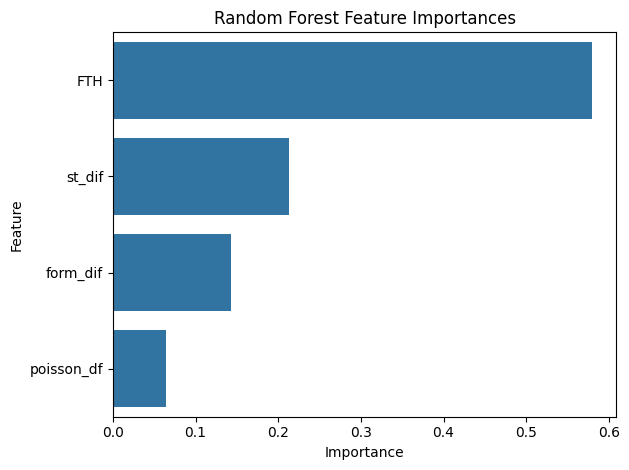

              precision    recall  f1-score   support

           0       0.67      0.65      0.66       913
           1       0.61      0.63      0.62       804

    accuracy                           0.64      1717
   macro avg       0.64      0.64      0.64      1717
weighted avg       0.64      0.64      0.64      1717

Confusion Matrix:
[[595 318]
 [298 506]]
ROC AUC Score: 0.6405254668606584


In [38]:
# Split the data into training and testing sets
X = df.drop(columns=['FTRT', 'HomeTeam', 'AwayTeam', 'ht_poisson_df', 'B365H', 'B365D', 'B365A'], axis = 1)  # Features
y = df['FTRT']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Random Forest
rf_model = BalancedRandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=10, min_samples_leaf=10, random_state=42,
                                          sampling_strategy = 'all', replacement = True, bootstrap = False)

# Train models
rf_model.fit(X_train, y_train)

# Predictions
rf_train_preds = rf_model.predict(X_train)
rf_test_preds = rf_model.predict(X_test)

# Accuracy scores
rf_train_accuracy = accuracy_score(y_train, rf_train_preds)
rf_test_accuracy = accuracy_score(y_test, rf_test_preds)

print("\nRandom Forest - Training Accuracy:", rf_train_accuracy)
print("Random Forest - Test Accuracy:", rf_test_accuracy)

rf_feature_importances = rf_model.feature_importances_

# Visualize feature importances
rf_feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_feature_importances})

sns.barplot(x='Importance', y='Feature', data=rf_feature_importances_df.sort_values(by='Importance', ascending=False))
plt.title('Random Forest Feature Importances')

plt.tight_layout()
plt.show()

# Print classification report
print(classification_report(y_test, rf_test_preds))

# Calculate and print confusion matrix
conf_matrix = confusion_matrix(y_test, rf_test_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, rf_test_preds)
print("ROC AUC Score:", roc_auc)

# Trying with Different Models

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Define models and their hyperparameter grids
models_and_parameters = {
    'Logistic Regression': (
        LogisticRegression(solver='liblinear'),
        {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]}
    ),
    'Random Forest': (
        RandomForestClassifier(),
        {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
    ),
    'Support Vector Machine': (
        SVC(probability=True),
        {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    ),
    'Naive Bayes': (
        GaussianNB(),
        {}  # No hyperparameters to tune in basic GaussianNB
    ),
    'Gradient Boosting': (
        GradientBoostingClassifier(),
        {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
    ),
    'Decision Tree': (
        DecisionTreeClassifier(),
        {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
    ),
    'k-Nearest Neighbors': (
        KNeighborsClassifier(),
        {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
    )
}

# Store results
grid_search_results = {}

for name, (model, param_grid) in models_and_parameters.items():
    print(f"Running GridSearchCV for {name}...")
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1  # Use all available cores
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    y_preds = best_model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    test_accuracy = accuracy_score(y_test, y_preds)
    
    grid_search_results[name] = {
        'best_params': grid_search.best_params_,
        'roc_auc': roc_auc,
        'accuracy': test_accuracy
    }

# Print results
print("\n📊 ROC AUC Scores and Best Parameters:")
for name, result in grid_search_results.items():
    print(f"{name}: Test Accuracy = {result['accuracy']:.4f} | Best Params: {result['best_params']}")


Running GridSearchCV for Logistic Regression...
Running GridSearchCV for Random Forest...
Running GridSearchCV for Support Vector Machine...
Running GridSearchCV for Naive Bayes...
Running GridSearchCV for Gradient Boosting...
Running GridSearchCV for Decision Tree...
Running GridSearchCV for k-Nearest Neighbors...

📊 ROC AUC Scores and Best Parameters:
Logistic Regression: Test Accuracy = 0.6639 | Best Params: {'C': 0.1, 'penalty': 'l2'}
Random Forest: Test Accuracy = 0.6587 | Best Params: {'max_depth': 10, 'n_estimators': 100}
Support Vector Machine: Test Accuracy = 0.6570 | Best Params: {'C': 0.1, 'kernel': 'linear'}
Naive Bayes: Test Accuracy = 0.6453 | Best Params: {}
Gradient Boosting: Test Accuracy = 0.6517 | Best Params: {'learning_rate': 0.01, 'n_estimators': 200}
Decision Tree: Test Accuracy = 0.6348 | Best Params: {'max_depth': 10, 'min_samples_split': 10}
k-Nearest Neighbors: Test Accuracy = 0.6296 | Best Params: {'n_neighbors': 7, 'weights': 'uniform'}


# Trying with Best Model (Support Vector Machine)


✅ ROC AUC Score: 0.7148

✅ Test Accuracy: 0.6570

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       913
           1       0.68      0.51      0.58       804

    accuracy                           0.66      1717
   macro avg       0.66      0.65      0.65      1717
weighted avg       0.66      0.66      0.65      1717


🧩 Confusion Matrix:
[[716 197]
 [392 412]]


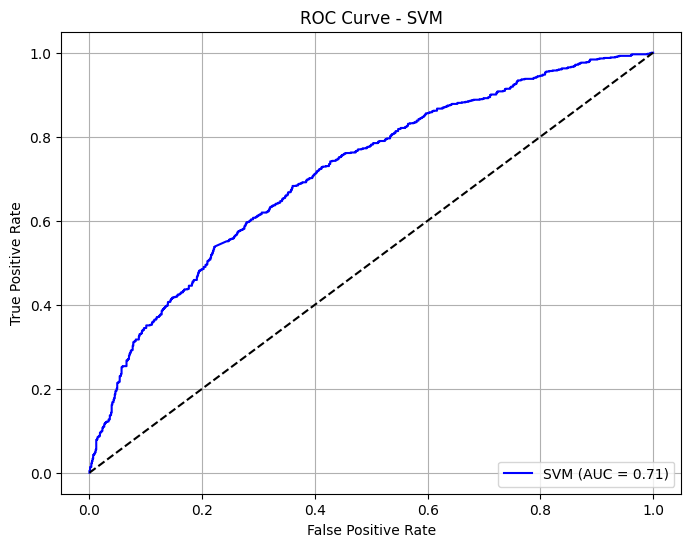

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Train the best SVM model
best_svm = SVC(C=0.1, kernel='linear', probability=True)
best_svm.fit(X_train, y_train)

# Predict probabilities and classes
svm_pred_proba = best_svm.predict_proba(X_test)[:, 1]
svm_pred = best_svm.predict(X_test)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, svm_pred_proba)
accuracy = accuracy_score(y_test, svm_pred)
print(f"\n✅ ROC AUC Score: {roc_auc:.4f}")
print(f"\n✅ Test Accuracy: {accuracy:.4f}")

# Classification report
print("\n📄 Classification Report:")
print(classification_report(y_test, svm_pred))

# Confusion Matrix
print("\n🧩 Confusion Matrix:")
print(confusion_matrix(y_test, svm_pred))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, svm_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"SVM (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Trying with 2nd Best Model (Logistic Regression)

ROC AUC Score: 0.7146768893756845

✅ Test Accuracy: 0.6558
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       913
           1       0.63      0.63      0.63       804

    accuracy                           0.66      1717
   macro avg       0.65      0.65      0.65      1717
weighted avg       0.66      0.66      0.66      1717



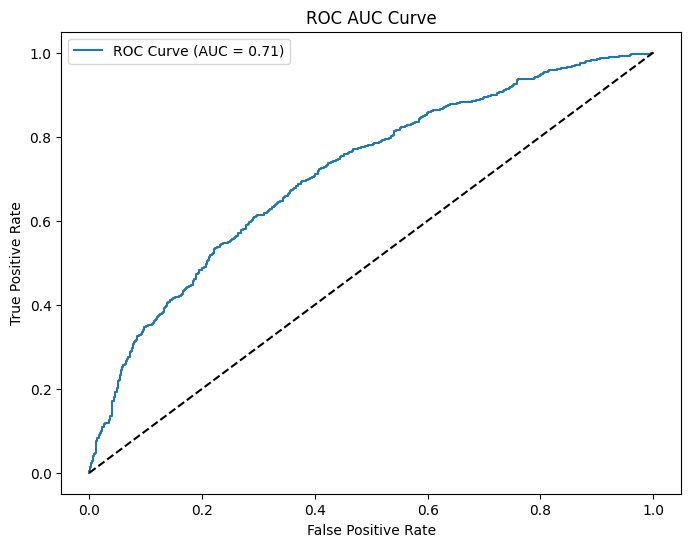

[[617 296]
 [295 509]]


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt

# Initialize and train Logistic Regression model with best hyperparameters
logistic_regression = LogisticRegression(C=0.1, class_weight='balanced', penalty='l2', solver='liblinear')
logistic_regression.fit(X_train, y_train)

# Generate predictions on the test set
log_pred_proba = logistic_regression.predict_proba(X_test)[:, 1]
log_pred = logistic_regression.predict(X_test)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, log_pred_proba)
accuracy = accuracy_score(y_test, log_pred)
print("ROC AUC Score:", roc_auc)
print(f"\n✅ Test Accuracy: {accuracy:.4f}")

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, log_pred))

# Plot ROC AUC curve
fpr, tpr, thresholds = roc_curve(y_test, log_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend()
plt.show()

print(confusion_matrix(y_test, log_pred))

# Calculating Profitability for the Original Dataframe

In [15]:
#Merging predictions with test set
merged_df = df.loc[X_test.index].copy()
merged_df['svm_pred'] = svm_pred
merged_df['log_pred'] = log_pred
merged_df[merged_df['svm_pred'] != merged_df['log_pred']].head()

,HomeTeam,AwayTeam,B365H,B365D,B365A,form_dif,st_dif,FTH,poisson_df,ht_poisson_df,FTRT,svm_pred,log_pred
2183,Wigan,Sunderland,2.05,3.30,4.0,0.366667,0.423913,0.468667,0.352941,0.5,0,0,1
5652,Newcastle,Bournemouth,2.00,3.50,4.2,0.733333,0.489130,0.488372,0.411765,0.5,0,0,1
2354,Blackburn,Newcastle,2.00,3.40,3.8,0.466667,0.478261,0.472914,0.294118,0.5,1,0,1
7498,Brentford,Leeds,2.10,3.50,3.4,0.600000,0.456522,0.450928,0.411765,0.5,1,0,1
221,Middlesbrough,Aston Villa,1.80,3.25,4.0,0.733333,0.434783,0.499040,0.470588,0.5,0,0,1


In [30]:
# Conditions Checking for profitability
cond_1 = (merged_df['FTRT'] == merged_df['svm_pred']) & (merged_df['svm_pred'] == 1) #change log to svm when needed
cond_2 = (merged_df['FTRT'] == merged_df['svm_pred']) & (merged_df['svm_pred'] == 0)
cond_3 = merged_df['FTRT'] != merged_df['svm_pred']

# Choices
choice_1 = merged_df['B365H'] - 1
choice_2 = (1 / ((1 / merged_df['B365D']) + (1 / merged_df['B365A']))) * 0.95 - 1
choice_3 = -1

# Assign new column
merged_df['Profit'] = np.select([cond_1, cond_2, cond_3], [choice_1, choice_2, choice_3])
merged_df['Proba'] = svm_pred_proba
print(merged_df['Profit'].sum())
print(merged_df['Profit'].sum() / len(merged_df['Profit']))
merged_df.head()

-132.5295450744411
-0.07718668903578399


,HomeTeam,AwayTeam,B365H,B365D,B365A,form_dif,st_dif,FTH,poisson_df,ht_poisson_df,FTRT,svm_pred,log_pred,Profit,Proba,Bankroll,exp_odds,bookie_odds,ev_bet
4952,Liverpool,West Brom,1.40,4.75,10.0,0.533333,0.510870,0.696992,0.352941,0.500000,0,1,1,-1.000000,0.720921,99.000000,1.405784,1.400000,0
6701,Man United,Crystal Palace,1.30,5.50,9.5,0.766667,0.586957,0.728223,0.529412,0.583333,0,1,1,-1.000000,0.760949,98.000000,1.342039,1.300000,0
6742,Man United,Chelsea,2.37,3.60,2.8,0.433333,0.315217,0.399240,0.352941,0.583333,0,0,0,0.496250,0.371032,98.496250,1.769979,1.496250,1
222,Sunderland,Southampton,2.50,3.20,2.5,0.433333,0.347826,0.359551,0.294118,0.500000,0,0,0,0.333333,0.338563,98.829583,1.682057,1.333333,1
5521,Burnley,West Brom,2.25,3.30,3.6,0.633333,0.369565,0.433498,0.352941,0.500000,0,0,0,0.635652,0.417994,99.465236,1.907348,1.635652,1


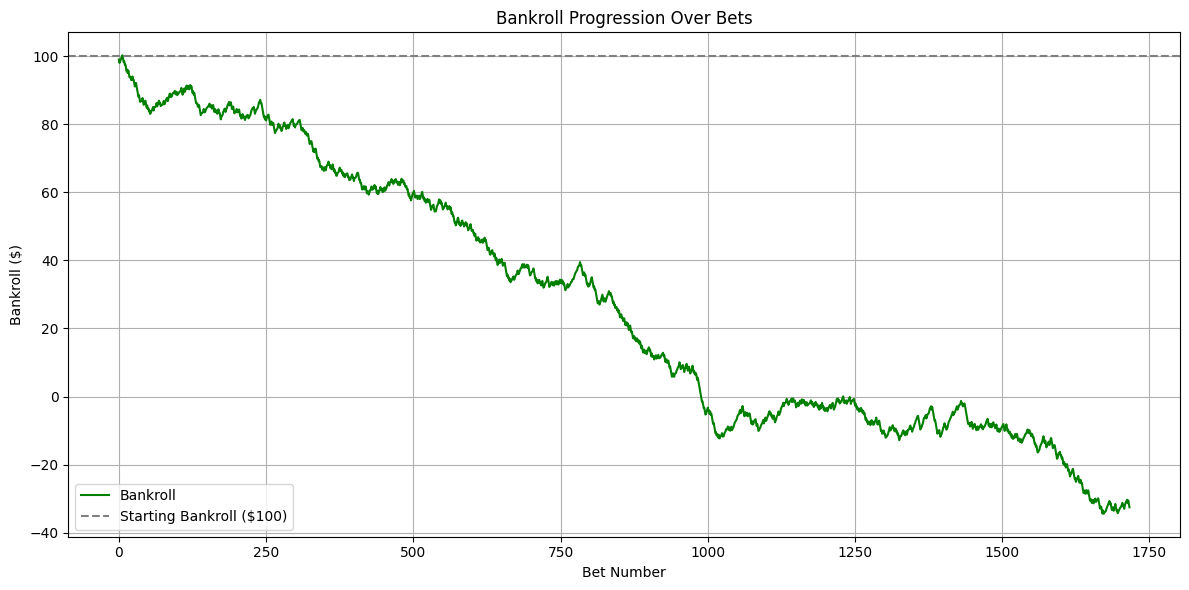

,HomeTeam,AwayTeam,B365H,B365D,B365A,form_dif,st_dif,FTH,poisson_df,ht_poisson_df,FTRT,svm_pred,log_pred,Profit,Proba,Bankroll,exp_odds,bookie_odds,ev_bet
4952,Liverpool,West Brom,1.40,4.75,10.0,0.533333,0.510870,0.696992,0.352941,0.500000,0,1,1,-1.000000,0.720921,99.000000,1.405784,1.400000,0
6701,Man United,Crystal Palace,1.30,5.50,9.5,0.766667,0.586957,0.728223,0.529412,0.583333,0,1,1,-1.000000,0.760949,98.000000,1.342039,1.300000,0
6742,Man United,Chelsea,2.37,3.60,2.8,0.433333,0.315217,0.399240,0.352941,0.583333,0,0,0,0.496250,0.371032,98.496250,1.769979,1.496250,1
222,Sunderland,Southampton,2.50,3.20,2.5,0.433333,0.347826,0.359551,0.294118,0.500000,0,0,0,0.333333,0.338563,98.829583,1.682057,1.333333,1
5521,Burnley,West Brom,2.25,3.30,3.6,0.633333,0.369565,0.433498,0.352941,0.500000,0,0,0,0.635652,0.417994,99.465236,1.907348,1.635652,1


In [31]:
import matplotlib.pyplot as plt

# Start with $100
starting_bankroll = 100

# Calculate cumulative bankroll
merged_df['Bankroll'] = starting_bankroll + merged_df['Profit'].cumsum()

# Plot it
plt.figure(figsize=(12, 6))
plt.plot(range(len(merged_df)), merged_df['Bankroll'], label='Bankroll', color='green')

# Optional: add horizontal line for starting bankroll
plt.axhline(y=starting_bankroll, color='gray', linestyle='--', label='Starting Bankroll ($100)')

# Labels and title
plt.xlabel('Bet Number')
plt.ylabel('Bankroll ($)')
plt.title('Bankroll Progression Over Bets')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

merged_df.head()

# Continuing with Pred Probas

In [32]:
profit_margin = 0.05

# Continue with pred_proba of the model
merged_df['exp_odds'] = np.where(
    merged_df['svm_pred'] == 1,
    1 / merged_df['Proba'],
    1 / (1 - merged_df['Proba'])
)

merged_df['bookie_odds'] = np.where(
    merged_df['svm_pred'] == 1,
    merged_df['B365H'],
    (1 / ((1 / merged_df['B365D']) + (1 / merged_df['B365A']))) * 0.95
)

merged_df['ev_bet'] = np.where(merged_df['exp_odds'] > (merged_df['bookie_odds'] + merged_df['bookie_odds'] * profit_margin), 1, 0)

merged_df.head()

,HomeTeam,AwayTeam,B365H,B365D,B365A,form_dif,st_dif,FTH,poisson_df,ht_poisson_df,FTRT,svm_pred,log_pred,Profit,Proba,Bankroll,exp_odds,bookie_odds,ev_bet
4952,Liverpool,West Brom,1.40,4.75,10.0,0.533333,0.510870,0.696992,0.352941,0.500000,0,1,1,-1.000000,0.720921,99.000000,1.387115,1.400000,0
6701,Man United,Crystal Palace,1.30,5.50,9.5,0.766667,0.586957,0.728223,0.529412,0.583333,0,1,1,-1.000000,0.760949,98.000000,1.314149,1.300000,0
6742,Man United,Chelsea,2.37,3.60,2.8,0.433333,0.315217,0.399240,0.352941,0.583333,0,0,0,0.496250,0.371032,98.496250,1.589905,1.496250,1
222,Sunderland,Southampton,2.50,3.20,2.5,0.433333,0.347826,0.359551,0.294118,0.500000,0,0,0,0.333333,0.338563,98.829583,1.511861,1.333333,1
5521,Burnley,West Brom,2.25,3.30,3.6,0.633333,0.369565,0.433498,0.352941,0.500000,0,0,0,0.635652,0.417994,99.465236,1.718195,1.635652,1


C:\Users\99451\AppData\Local\Temp\ipykernel_13592\4021871502.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev_bets['Bankroll'] = starting_bankroll + ev_bets['Profit'].cumsum()


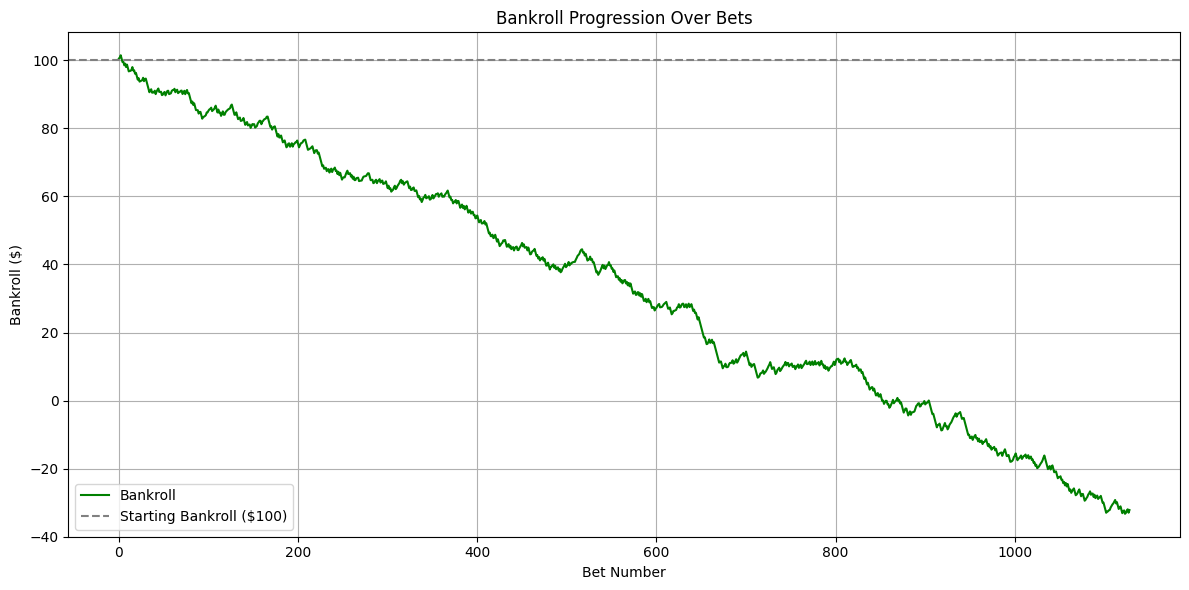

-132.18063300689866
-0.11707762002382521


,HomeTeam,AwayTeam,B365H,B365D,B365A,form_dif,st_dif,FTH,poisson_df,ht_poisson_df,FTRT,svm_pred,log_pred,Profit,Proba,Bankroll,exp_odds,bookie_odds,ev_bet
6742,Man United,Chelsea,2.37,3.60,2.8,0.433333,0.315217,0.399240,0.352941,0.583333,0,0,0,0.496250,0.371032,100.496250,1.589905,1.496250,1
222,Sunderland,Southampton,2.50,3.20,2.5,0.433333,0.347826,0.359551,0.294118,0.500000,0,0,0,0.333333,0.338563,100.829583,1.511861,1.333333,1
5521,Burnley,West Brom,2.25,3.30,3.6,0.633333,0.369565,0.433498,0.352941,0.500000,0,0,0,0.635652,0.417994,101.465236,1.718195,1.635652,1
2758,Burnley,West Ham,2.60,3.25,2.8,0.566667,0.434783,0.366492,0.352941,0.500000,1,0,0,-1.000000,0.361571,100.465236,1.566345,1.428926,1
4860,Stoke,Bournemouth,2.55,3.30,3.0,0.566667,0.485507,0.381282,0.470588,0.666667,1,0,0,-1.000000,0.386018,99.465236,1.628713,1.492857,1


In [33]:
ev_bets = merged_df[merged_df['ev_bet'] == 1]

# Start with $100
starting_bankroll = 100

# Calculate cumulative bankroll
ev_bets['Bankroll'] = starting_bankroll + ev_bets['Profit'].cumsum()

# Plot it
plt.figure(figsize=(12, 6))
plt.plot(range(len(ev_bets)), ev_bets['Bankroll'], label='Bankroll', color='green')

# Optional: add horizontal line for starting bankroll
plt.axhline(y=starting_bankroll, color='gray', linestyle='--', label='Starting Bankroll ($100)')

# Labels and title
plt.xlabel('Bet Number')
plt.ylabel('Bankroll ($)')
plt.title('Bankroll Progression Over Bets')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(ev_bets['Profit'].sum())
print(ev_bets['Profit'].sum() / len(ev_bets['Profit']))
ev_bets.head()

# Trying To Optimize Profit Using Odds Differences

0.3662969250695334 0.5410773136938394


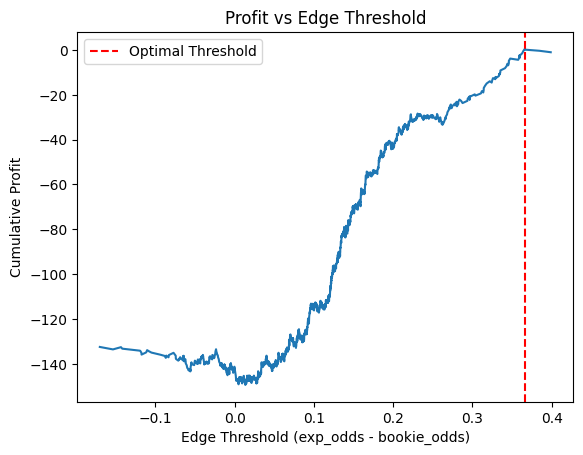

,HomeTeam,AwayTeam,B365H,B365D,B365A,form_dif,st_dif,FTH,poisson_df,ht_poisson_df,FTRT,svm_pred,log_pred,Profit,Proba,Bankroll,exp_odds,bookie_odds,ev_bet,edge
445,Bolton,Birmingham,2.400,3.20,2.70,0.566667,0.728261,0.378947,0.352941,0.5,0,0,0,0.391186,0.431005,14.120908,1.757483,1.391186,1,0.366297
1470,Newcastle,Bolton,2.250,3.20,3.10,0.666667,0.706522,0.411704,0.411765,0.5,0,0,1,0.495873,0.463018,-3.203674,1.862259,1.495873,1,0.366386
486,Bolton,Everton,2.250,3.25,2.87,0.633333,0.728261,0.403832,0.352941,0.5,1,0,1,-1.000000,0.458502,-3.827422,1.846728,1.447896,1,0.398832
167,Liverpool,Everton,1.833,3.25,3.75,0.533333,0.532609,0.487140,0.352941,0.5,0,0,1,0.654018,0.509448,-8.802199,2.038520,1.654018,1,0.384502


In [43]:
merged_df['edge'] = merged_df['exp_odds'] - merged_df['bookie_odds']
df_sorted = merged_df.sort_values(by='edge', ascending=False).reset_index(drop=True)
df_sorted['cum_profit'] = df_sorted['Profit'].cumsum()
max_profit_idx = df_sorted['cum_profit'].idxmax()

optimal_edge_threshold = df_sorted.loc[max_profit_idx, 'edge']
max_profit = df_sorted.loc[max_profit_idx, 'cum_profit']
print(optimal_edge_threshold, max_profit)

optimal_df = merged_df[merged_df['edge'] >= optimal_edge_threshold]

plt.plot(df_sorted['edge'], df_sorted['cum_profit'])
plt.xlabel('Edge Threshold (exp_odds - bookie_odds)')
plt.ylabel('Cumulative Profit')
plt.title('Profit vs Edge Threshold')
plt.axvline(optimal_edge_threshold, color='red', linestyle='--', label='Optimal Threshold')
plt.legend()
plt.show()

optimal_df.head()